In [2]:
import geopandas as gpd
from tqdm import tqdm
import libpysal as lp
import json
import pandas as pd
from matplotlib.patches import Patch  # used for the plot legends later

###  Get the data in the folder ./LCPS_data for pre-processing. Let's call this `retrieved data`.

In [3]:
def retrieve_data(sy):
    """
    Retrieve data for a given school year (sy)
    """
    data_dir = "./LCPS_data"
    # Read the data files
    schools = gpd.read_file('{}/LCPS_Sites_{}.shp'.format(data_dir, sy))
    students = gpd.read_file('{}/Students_{}.shp'.format(data_dir, sy))
    spas = gpd.read_file('{}/PlanningZones_{}.shp'.format(data_dir, sy))
    
    return schools, students, spas


In [4]:
sy = '2017_2018'

In [5]:
# raw_schools, raw_students, raw_spas = retrieve_data(sy)

###  Get the processed data from the folder ./data

In [6]:
#spas_processed = gpd.read_file('new_SPAs_2017_2018.json', driver='GeoJSON')
spas = gpd.read_file('./data/new_SPAs_2017_2018.json', driver='GeoJSON')
students = gpd.read_file('./data/new_Students_2017_2018.json', driver='GeoJSON')
schools = gpd.read_file('./data/new_Schools_2017_2018.json', driver='GeoJSON')




#new line to run the newly downloaded json files, should move around anywhere.
#new line to run the newly downloaded json files, should move around anywhere.

In [7]:
#students.head()
#schools.head()
spas.head()

#uncomment the one you want to see

,OBJECTID,COUNT_,SPA,ELEM_,INT_,HIGH_,ELEM_CODE,MID_CODE,HIGH_CODE,DISTRICT,...,HIGH_POP_N,HIGH_POP_P,TOT_POP_A,TOT_POP_W,TOT_POP_M2,TOT_POP_B,TOT_POP_H,TOT_POP_N,TOT_POP_P,geometry
0,1,5.0,WL03.4,126,205,311,LOV,HRM,WHS,WL,...,0,0,1,37,0,2,7,0,0,"POLYGON ((11725868.086 7152149.054, 11725870.6..."
1,2,5.0,WL03,126,205,311,LOV,HRM,WHS,WL,...,0,0,0,83,5,0,6,1,0,"POLYGON ((11726805.147 7160565.439, 11726826.6..."
2,3,5.0,WL27.2,118,202,305,HAM,BRM,LVH,WL,...,0,0,0,11,0,1,5,0,0,"POLYGON ((11720159.464 7099502.139, 11720172.1..."
3,4,5.0,WL32.1,132,205,311,MTV,HRM,WHS,WL,...,0,0,8,205,14,8,23,1,0,"POLYGON ((11694466.485 7097608.657, 11694418.5..."
4,5,5.0,WL02,126,205,311,LOV,HRM,WHS,WL,...,0,0,9,170,3,0,5,0,0,"POLYGON ((11715899.154 7166497.655, 11715932.1..."


## Analysis Using New SPAs Data

In [8]:
spas.keys()

Index(['OBJECTID', 'COUNT_', 'SPA', 'ELEM_', 'INT_', 'HIGH_', 'ELEM_CODE',
       'MID_CODE', 'HIGH_CODE', 'DISTRICT', 'UTILITIES', 'SHAPE_Leng',
       'SHAPE_Area', 'STDYAREA_1', 'DISTRICT_1', 'PLANNING_Z', 'ELEM', 'MID',
       'HIGH', 'UTILITIE_1', 'DISTRICT_2', 'MID_2018', 'HIGH_2018', 'PK', 'KG',
       'GR1', 'GR2', 'GR3', 'GR4', 'GR5', 'GR6', 'GR7', 'GR8', 'GR9', 'GR10',
       'GR11', 'GR12', 'TOTAL_KG_5', 'TOTAL_6_8', 'TOTAL_9_12', 'TOTAL_KG_1',
       'TOTAL_PK_1', 'ELEM_POP', 'MID_POP', 'HIGH_POP', 'TOT_POP',
       'ELEM_POP_A', 'ELEM_POP_W', 'ELEM_POP_M2', 'ELEM_POP_B', 'ELEM_POP_H',
       'ELEM_POP_N', 'ELEM_POP_P', 'MID_POP_A', 'MID_POP_W', 'MID_POP_M2',
       'MID_POP_B', 'MID_POP_H', 'MID_POP_N', 'MID_POP_P', 'HIGH_POP_A',
       'HIGH_POP_W', 'HIGH_POP_M2', 'HIGH_POP_B', 'HIGH_POP_H', 'HIGH_POP_N',
       'HIGH_POP_P', 'TOT_POP_A', 'TOT_POP_W', 'TOT_POP_M2', 'TOT_POP_B',
       'TOT_POP_H', 'TOT_POP_N', 'TOT_POP_P', 'geometry'],
      dtype='object')

In [497]:
# Choose possible grade level; ELEM, MID, HIGH for SPAs

grade = 'ELEM'
asians = '{}_POP_A'.format(grade)
whites = '{}_POP_W'.format(grade)
mixed = '{}_POP_M2'.format(grade)
blacks = '{}_POP_B'.format(grade)
hispanics = '{}_POP_H'.format(grade)
natives = '{}_POP_N'.format(grade)
pacifics = '{}_POP_P'.format(grade)
non_whites = '{}_POP_NW'.format(grade)


spas_ethnic = spas[['{}_CODE'.format(grade) , asians, whites, mixed, blacks, hispanics, natives, pacifics, '{}_POP'.format(grade)]]
spas_ethnic.loc[:, non_whites] = spas_ethnic.loc[:, asians] +  spas_ethnic.loc[:,blacks] +  spas_ethnic.loc[:,mixed] \
                            + spas_ethnic.loc[:,hispanics] + spas_ethnic.loc[:,natives] + spas_ethnic.loc[:,pacifics]
spas_grouped_raw = spas_ethnic.groupby(['{}_CODE'.format(grade) ]).sum()
spas_grouped = spas_grouped_raw.div(spas_grouped_raw['{}_POP'.format(grade)], axis=0)
spas_grouped.drop([asians, mixed, blacks, hispanics, natives, pacifics, '{}_POP'.format(grade)], axis='columns', inplace=True)
spas_grouped.head()

#when generalizing one place to change and use the FORMAT style

C:\Users\james\Anaconda3\lib\site-packages\pandas\core\indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\james\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,ELEM_POP_W,ELEM_POP_NW
ELEM_CODE,,
ALD,0.596939,0.403061
ALG,0.640177,0.359823
ARC,0.381497,0.618503
ASH,0.490939,0.509061
BAL,0.553398,0.446602


In [498]:
#NOTE: Run this only once or start from the previous cell on subsequent runs - since we use iterrows and create a new column, the calculated value will change on the next runs

def get_measurements(df):
    from numpy import log
    import itertools
    
    # calculate absolute differences
    abs_diffs = []
    for row in df.iterrows():
    #     print([val for val in itertools.permutations(row[1], 2)])
    #     break
        diffs = [abs(val[1] - val[0]) for val in itertools.permutations(row[1], 2)]
        total = sum(diffs)/2
        abs_diffs.append(total)
    df.loc[:,'ABS_DIFF'] = abs_diffs

    # calculate dissimilarity index
    ind_diss = 0.5 * sum(abs(df[whites]/df[whites].sum() - df[non_whites]/df[non_whites].sum()))

    # calculate entropy index
    entropy = -(df[non_whites]*log(df[non_whites]) + df[whites]*log(df[whites]))
    entropy.replace(float('NaN'),0, inplace=True)

    df.loc[:,'ENTROPY_IND'] = entropy

    return df, ind_diss



In [499]:
measurements_df, ind_diss_sa1 = get_measurements(spas_grouped)
segregated_abs_diff = measurements_df[measurements_df['ABS_DIFF'] > 0.7]
segregated_entropy = measurements_df[measurements_df['ENTROPY_IND'] < 0.4]
print(ind_diss_sa1)
segregated_entropy

0.3092111479501929


,ELEM_POP_W,ELEM_POP_NW,ABS_DIFF,ENTROPY_IND
ELEM_CODE,,,,
GUI,0.079687,0.920312,0.840625,0.278005
LIN,0.884211,0.115789,0.768421,0.358451
SUG,0.135400,0.864600,0.729201,0.396524
SUL,0.111111,0.888889,0.777778,0.348832


In [501]:
measurements_df.loc[interested_districts,:]

,ELEM_POP_W,ELEM_POP_NW,ABS_DIFF,ENTROPY_IND
ELEM_CODE,,,,
GUI,0.079687,0.920312,0.840625,0.278005
SUL,0.111111,0.888889,0.777778,0.348832
LIN,0.884211,0.115789,0.768421,0.358451
FHR,0.579161,0.420839,0.158322,0.680561
HAM,0.803468,0.196532,0.606936,0.495557
KWC,0.837121,0.162879,0.674242,0.444413
WAT,0.814815,0.185185,0.629630,0.479166
EVE,0.475687,0.524313,0.048626,0.691964
FDE,0.361496,0.638504,0.277008,0.654274


In [12]:
ax, props = spas_grouped.boxplot(column=[whites, non_whites], figsize=(12,8), return_type='both')

## Conclusions for Original Data


Overall, using the dissimilarity index (0.3), there does not appear to be much segregation within the districts.

However, individually, using the absolute differences (0.7 cut-off) and entropy index (0.4 cut-off), there seems to be evidence of segregation in 4 districts; GUI, LIN, SUL and SUG. 


In [13]:
segregated_abs_diff

,ELEM_POP_W,ELEM_POP_NW,ABS_DIFF,ENTROPY_IND
ELEM_CODE,,,,
GUI,0.079687,0.920312,0.840625,0.278005
LIN,0.884211,0.115789,0.768421,0.358451
SUG,0.135400,0.864600,0.729201,0.396524
SUL,0.111111,0.888889,0.777778,0.348832


In [14]:
segregated_entropy

,ELEM_POP_W,ELEM_POP_NW,ABS_DIFF,ENTROPY_IND
ELEM_CODE,,,,
GUI,0.079687,0.920312,0.840625,0.278005
LIN,0.884211,0.115789,0.768421,0.358451
SUG,0.135400,0.864600,0.729201,0.396524
SUL,0.111111,0.888889,0.777778,0.348832


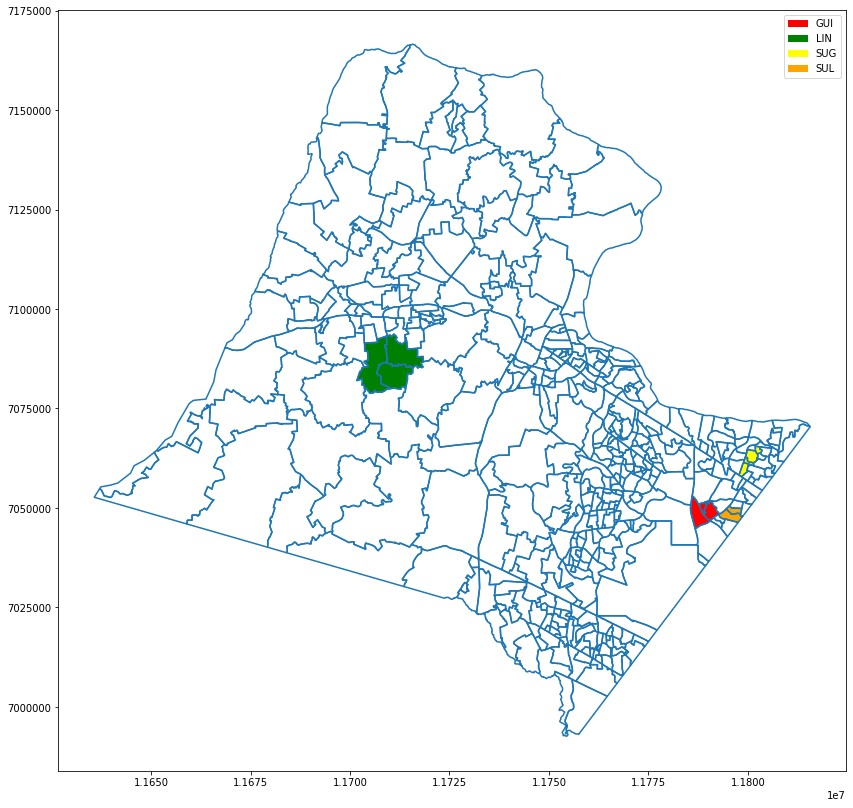

In [15]:
legend_handles = [Patch(facecolor='red', label='GUI'),
                Patch(facecolor='green', label='LIN'),
                Patch(facecolor='yellow', label='SUG'),
                Patch(facecolor='orange', label='SUL')]

ax = spas.boundary.plot(figsize=(15,14))
spas[spas['ELEM_CODE'] == 'GUI'].plot(ax=ax, color='red')
spas[spas['ELEM_CODE'] == 'LIN'].plot(ax=ax, color='green')
spas[spas['ELEM_CODE'] == 'SUG'].plot(ax=ax, color='yellow')
spas[spas['ELEM_CODE'] == 'SUL'].plot(ax=ax, color='orange')
# ax.legend
ax.legend(handles=legend_handles)

# Comparison to data generated by Algorithms

In [16]:
#spas_processed = gpd.read_file('new_SPAs_2017_2018.json', driver='GeoJSON')
# sa = json.loads('./results/SA/run7_ES_SA.json')
# shc = gpd.read_file('./results/SHC/run7_ES_SHC.json', driver='GeoJSON')
# ts = gpd.read_file('./results/TS/run7_ES_TS.json', driver='GeoJSON')

import json

def retrieve_output_data(algo, level, plan):
    output_df = pd.DataFrame({"SPA": [], "NEW_{}_CODE".format(grade): []})  #grade is a global variable
    result_dir = 'results'
    #Load the file as json. 
    with open('{}/{}/run7_{}_{}.json'.format(result_dir, algo, level, algo)) as file:
        #readlines() reads the file as string and loads() loads it into a dict
        obj = json.loads(''.join(file.readlines()))

        #Then iterate its items() as key value pairs
        for spa_code, elem_code in obj[str(plan)]['info']['Final']['zoneIds'].items():
            output_df.loc[len(output_df.index)] = [spa_code, elem_code]

    return output_df
#new line to run the newly downloaded json files, should move around anywhere.

In [17]:
import numpy as np
interested_districts = ["GUI", "SUL", "LIN", "FHR", "HAM", "KWC", "WAT", "EVE", "FDE", "SUG"]
data_array = np.zeros([25, 2*len(interested_districts)])
# data_array = np.array([])

# Try to make dynamic later

In [18]:
def group_data(merged_spas):
    merged_spas_ethnic = merged_spas[['NEW_{}_CODE'.format(grade) , asians, whites, mixed, blacks, hispanics, natives, pacifics, '{}_POP'.format(grade), 'geometry']]
    merged_spas_ethnic.loc[:, non_whites] = merged_spas_ethnic.loc[:, asians] +  merged_spas_ethnic.loc[:,blacks] +  merged_spas_ethnic.loc[:,mixed] \
                                + merged_spas_ethnic.loc[:,hispanics] + merged_spas_ethnic.loc[:,natives] + merged_spas_ethnic.loc[:,pacifics]
    merged_spa_grouped_raw = merged_spas_ethnic.groupby(['NEW_{}_CODE'.format(grade) ]).sum()
    merged_spa_grouped = merged_spa_grouped_raw.div(merged_spa_grouped_raw['ELEM_POP'], axis=0)
    merged_spa_grouped.drop([asians, mixed, blacks, hispanics, natives, pacifics, '{}_POP'.format(grade)], axis='columns', inplace=True)
    return merged_spa_grouped


In [19]:
ind_diss = []

## Output Plan 1

### Simulated Annealing (SA)

In [412]:
plan = 1
algo = 'SA'
sa_output_df = retrieve_output_data(algo, 'ES', plan)
new_spas_sa = pd.merge(spas, sa_output_df, on='SPA')
new_spas_sa_grouped = group_data(new_spas_sa)
vals = np.concatenate([new_spas_sa_grouped.loc[i,:].values for i in interested_districts])
data_array[plan-1,:] = vals

new_spas_sa_grouped.head()
#To change everything down to SA or TS

C:\Users\james\Anaconda3\lib\site-packages\pandas\core\indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\james\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,ELEM_POP_W,ELEM_POP_NW
NEW_ELEM_CODE,,
ALD,0.558587,0.441413
ALG,0.437313,0.562687
ASH,0.368353,0.631647
BAL,0.633448,0.366552
BAN,0.757339,0.242661


In [413]:
measurements_df, ind_diss_sa1 = get_measurements(new_spas_sa_grouped)
segregated_abs_diff_sa1 = measurements_df[measurements_df['ABS_DIFF'] > 0.7]
segregated_entropy_sa1 = measurements_df[measurements_df['ENTROPY_IND'] < 0.4]
ind_diss.append(ind_diss_sa1)
print(ind_diss_sa1)
segregated_entropy_sa1

0.3411405684367161


,ELEM_POP_W,ELEM_POP_NW,ABS_DIFF,ENTROPY_IND
NEW_ELEM_CODE,,,,
FDE,0.091954,0.908046,0.816092,0.307036
GUI,0.069565,0.930435,0.860870,0.252513
SUL,0.115502,0.884498,0.768997,0.357865


## Output Plan 2

### Simulated Annealing (SA)

In [414]:
plan = 2
sa_output_df = retrieve_output_data(algo, 'ES', plan)
new_spas_sa = pd.merge(spas, sa_output_df, on='SPA')
new_spas_sa_grouped = group_data(new_spas_sa)
vals = np.concatenate([new_spas_sa_grouped.loc[i,:].values for i in interested_districts])
data_array[plan-1,:] = vals

new_spas_sa_grouped.head()
#To change everything down to SA or TS

,ELEM_POP_W,ELEM_POP_NW
NEW_ELEM_CODE,,
ALD,0.580645,0.419355
ALG,0.609848,0.390152
ASH,0.434783,0.565217
BAL,0.383747,0.616253
BAN,0.450980,0.549020


In [415]:
measurements_df, ind_diss_sa1 = get_measurements(new_spas_sa_grouped)
segregated_abs_diff_sa2 = measurements_df[measurements_df['ABS_DIFF'] > 0.7]
segregated_entropy_sa2 = measurements_df[measurements_df['ENTROPY_IND'] < 0.4]
ind_diss.append(ind_diss_sa1)
print(ind_diss_sa1)
segregated_entropy_sa2

0.3185294639996755


,ELEM_POP_W,ELEM_POP_NW,ABS_DIFF,ENTROPY_IND
NEW_ELEM_CODE,,,,
GUI,0.133333,0.866667,0.733333,0.392674
SUL,0.111111,0.888889,0.777778,0.348832


## Output Plan 3

### Simulated Annealing (SA)

In [416]:
plan = 3
sa_output_df = retrieve_output_data(algo, 'ES', plan)
new_spas_sa = pd.merge(spas, sa_output_df, on='SPA')
new_spas_sa_grouped = group_data(new_spas_sa)
vals = np.concatenate([new_spas_sa_grouped.loc[i,:].values for i in interested_districts])
data_array[plan-1,:] = vals

new_spas_sa_grouped.head()
#To change everything down to SA or TS

,ELEM_POP_W,ELEM_POP_NW
NEW_ELEM_CODE,,
ALD,0.595186,0.404814
ALG,0.481700,0.518300
ASH,0.478678,0.521322
BAL,0.656740,0.343260
BAN,0.694779,0.305221


In [417]:
measurements_df, ind_diss_sa1 = get_measurements(new_spas_sa_grouped)
segregated_abs_diff_sa3 = measurements_df[measurements_df['ABS_DIFF'] > 0.7]
segregated_entropy_sa3 = measurements_df[measurements_df['ENTROPY_IND'] < 0.4]
ind_diss.append(ind_diss_sa1)
print(ind_diss_sa1)
segregated_entropy_sa3

0.31927487928917014


,ELEM_POP_W,ELEM_POP_NW,ABS_DIFF,ENTROPY_IND
NEW_ELEM_CODE,,,,
SUL,0.120053,0.879947,0.759894,0.367030
WAT,0.893939,0.106061,0.787879,0.338199


## Output Plan 4

### Simulated Annealing (SA)

In [418]:
plan = 4
sa_output_df = retrieve_output_data(algo, 'ES', plan)
new_spas_sa = pd.merge(spas, sa_output_df, on='SPA')
new_spas_sa_grouped = group_data(new_spas_sa)
vals = np.concatenate([new_spas_sa_grouped.loc[i,:].values for i in interested_districts])
data_array[plan-1,:] = vals

new_spas_sa_grouped.head()
#To change everything down to SA or TS

,ELEM_POP_W,ELEM_POP_NW
NEW_ELEM_CODE,,
ALD,0.596234,0.403766
ALG,0.594421,0.405579
ASH,0.409146,0.590854
BAL,0.302824,0.697176
BAN,0.700000,0.300000


In [419]:
measurements_df, ind_diss_sa1 = get_measurements(new_spas_sa_grouped)
segregated_abs_diff_sa4 = measurements_df[measurements_df['ABS_DIFF'] > 0.7]
segregated_entropy_sa4 = measurements_df[measurements_df['ENTROPY_IND'] < 0.4]
ind_diss.append(ind_diss_sa1)
print(ind_diss_sa1)
segregated_entropy_sa4

0.3538578383566726


,ELEM_POP_W,ELEM_POP_NW,ABS_DIFF,ENTROPY_IND
NEW_ELEM_CODE,,,,
FHR,0.877551,0.122449,0.755102,0.371776
LIN,0.877193,0.122807,0.754386,0.372481
SUL,0.113475,0.886525,0.773050,0.353720


## Output Plan 5

### Simulated Annealing (SA)

In [420]:
plan = 5
sa_output_df = retrieve_output_data(algo, 'ES', plan)
new_spas_sa = pd.merge(spas, sa_output_df, on='SPA')
new_spas_sa_grouped = group_data(new_spas_sa)
vals = np.concatenate([new_spas_sa_grouped.loc[i,:].values for i in interested_districts])
data_array[plan-1,:] = vals

new_spas_sa_grouped.head()
#To change everything down to SA or TS

,ELEM_POP_W,ELEM_POP_NW
NEW_ELEM_CODE,,
ALD,0.660784,0.339216
ALG,0.467449,0.532551
ASH,0.533557,0.466443
BAL,0.548176,0.451824
BAN,0.754591,0.245409


In [421]:
measurements_df, ind_diss_sa1 = get_measurements(new_spas_sa_grouped)
segregated_abs_diff_sa5 = measurements_df[measurements_df['ABS_DIFF'] > 0.7]
segregated_entropy_sa5 = measurements_df[measurements_df['ENTROPY_IND'] < 0.4]
ind_diss.append(ind_diss_sa1)
print(ind_diss_sa1)
segregated_entropy_sa5

0.3362985692728846


,ELEM_POP_W,ELEM_POP_NW,ABS_DIFF,ENTROPY_IND
NEW_ELEM_CODE,,,,
GUI,0.094523,0.905477,0.810954,0.312879
HAM,0.863636,0.136364,0.727273,0.398307


## Output Plan 6

### Simulated Annealing (SA)

In [422]:
plan = 6
sa_output_df = retrieve_output_data(algo, 'ES', plan)
new_spas_sa = pd.merge(spas, sa_output_df, on='SPA')
new_spas_sa_grouped = group_data(new_spas_sa)
vals = np.concatenate([new_spas_sa_grouped.loc[i,:].values for i in interested_districts])
data_array[plan-1,:] = vals

new_spas_sa_grouped.head()
#To change everything down to SA or TS

,ELEM_POP_W,ELEM_POP_NW
NEW_ELEM_CODE,,
ALD,0.481013,0.518987
ALG,0.428360,0.571640
ASH,0.476048,0.523952
BAL,0.522926,0.477074
BAN,0.725552,0.274448


In [423]:
measurements_df, ind_diss_sa1 = get_measurements(new_spas_sa_grouped)
segregated_abs_diff_sa6 = measurements_df[measurements_df['ABS_DIFF'] > 0.7]
segregated_entropy_sa6 = measurements_df[measurements_df['ENTROPY_IND'] < 0.4]
ind_diss.append(ind_diss_sa1)
print(ind_diss_sa1)
segregated_entropy_sa6

0.3374409932157744


,ELEM_POP_W,ELEM_POP_NW,ABS_DIFF,ENTROPY_IND
NEW_ELEM_CODE,,,,
KWC,0.914286,0.085714,0.828571,0.292508
SUL,0.109551,0.890449,0.780899,0.345575


## Output Plan 7

### Simulated Annealing (SA)

In [424]:
plan = 7
sa_output_df = retrieve_output_data(algo, 'ES', plan)
new_spas_sa = pd.merge(spas, sa_output_df, on='SPA')
new_spas_sa_grouped = group_data(new_spas_sa)
vals = np.concatenate([new_spas_sa_grouped.loc[i,:].values for i in interested_districts])
data_array[plan-1,:] = vals

new_spas_sa_grouped.head()
#To change everything down to SA or TS

,ELEM_POP_W,ELEM_POP_NW
NEW_ELEM_CODE,,
ALD,0.493421,0.506579
ALG,0.471111,0.528889
ASH,0.421687,0.578313
BAL,0.380868,0.619132
BAN,0.653696,0.346304


In [425]:
measurements_df, ind_diss_sa1 = get_measurements(new_spas_sa_grouped)
segregated_abs_diff_sa7 = measurements_df[measurements_df['ABS_DIFF'] > 0.7]
segregated_entropy_sa7 = measurements_df[measurements_df['ENTROPY_IND'] < 0.4]
ind_diss.append(ind_diss_sa1)
print(ind_diss_sa1)
segregated_entropy_sa7

0.32283176057848634


,ELEM_POP_W,ELEM_POP_NW,ABS_DIFF,ENTROPY_IND
NEW_ELEM_CODE,,,,
GUI,0.069565,0.930435,0.860870,0.252513
HAM,0.887500,0.112500,0.775000,0.351710
SUL,0.122396,0.877604,0.755208,0.371671


## Output Plan 8

### Simulated Annealing (SA)

In [426]:
plan = 8
sa_output_df = retrieve_output_data(algo, 'ES', plan)
new_spas_sa = pd.merge(spas, sa_output_df, on='SPA')
new_spas_sa_grouped = group_data(new_spas_sa)
vals = np.concatenate([new_spas_sa_grouped.loc[i,:].values for i in interested_districts])
data_array[plan-1,:] = vals

new_spas_sa_grouped.head()
#To change everything down to SA or TS

,ELEM_POP_W,ELEM_POP_NW
NEW_ELEM_CODE,,
ALD,0.592593,0.407407
ALG,0.546875,0.453125
ASH,0.449925,0.550075
BAL,0.560201,0.439799
BAN,0.435714,0.564286


In [427]:
measurements_df, ind_diss_sa1 = get_measurements(new_spas_sa_grouped)
segregated_abs_diff_sa8 = measurements_df[measurements_df['ABS_DIFF'] > 0.7]
segregated_entropy_sa8 = measurements_df[measurements_df['ENTROPY_IND'] < 0.4]
ind_diss.append(ind_diss_sa1)
print(ind_diss_sa1)
segregated_entropy_sa8

0.35414229645700784


,ELEM_POP_W,ELEM_POP_NW,ABS_DIFF,ENTROPY_IND
NEW_ELEM_CODE,,,,
FDE,0.121751,0.878249,0.756498,0.370399
GUI,0.069565,0.930435,0.860870,0.252513
LIN,0.862876,0.137124,0.725753,0.399708
SUL,0.127168,0.872832,0.745665,0.380967


## Output Plan 9

### Simulated Annealing (SA)

In [428]:
plan = 9
sa_output_df = retrieve_output_data(algo, 'ES', plan)
new_spas_sa = pd.merge(spas, sa_output_df, on='SPA')
new_spas_sa_grouped = group_data(new_spas_sa)
vals = np.concatenate([new_spas_sa_grouped.loc[i,:].values for i in interested_districts])
data_array[plan-1,:] = vals

new_spas_sa_grouped.head()
#To change everything down to SA or TS

,ELEM_POP_W,ELEM_POP_NW
NEW_ELEM_CODE,,
ALD,0.603550,0.396450
ALG,0.548344,0.451656
ASH,0.503401,0.496599
BAL,0.474099,0.525901
BAN,0.730769,0.269231


In [429]:
measurements_df, ind_diss_sa1 = get_measurements(new_spas_sa_grouped)
segregated_abs_diff_sa9 = measurements_df[measurements_df['ABS_DIFF'] > 0.7]
segregated_entropy_sa9 = measurements_df[measurements_df['ENTROPY_IND'] < 0.4]
ind_diss.append(ind_diss_sa1)
print(ind_diss_sa1)
segregated_entropy_sa9

0.3044650591987197


,ELEM_POP_W,ELEM_POP_NW,ABS_DIFF,ENTROPY_IND
NEW_ELEM_CODE,,,,
GUI,0.08821,0.91179,0.823581,0.298376


## Output Plan 10

### Simulated Annealing (SA)

In [430]:
plan = 10
sa_output_df = retrieve_output_data(algo, 'ES', plan)
new_spas_sa = pd.merge(spas, sa_output_df, on='SPA')
new_spas_sa_grouped = group_data(new_spas_sa)
vals = np.concatenate([new_spas_sa_grouped.loc[i,:].values for i in interested_districts])
data_array[plan-1,:] = vals

new_spas_sa_grouped.head()
#To change everything down to SA or TS

,ELEM_POP_W,ELEM_POP_NW
NEW_ELEM_CODE,,
ALD,0.604651,0.395349
ALG,0.533981,0.466019
ASH,0.503153,0.496847
BAL,0.477215,0.522785
BAN,0.763780,0.236220


In [431]:
measurements_df, ind_diss_sa1 = get_measurements(new_spas_sa_grouped)
segregated_abs_diff_sa10 = measurements_df[measurements_df['ABS_DIFF'] > 0.7]
segregated_entropy_sa10 = measurements_df[measurements_df['ENTROPY_IND'] < 0.4]
ind_diss.append(ind_diss_sa1)
print(ind_diss_sa1)
segregated_entropy_sa10

0.32154887812227184


,ELEM_POP_W,ELEM_POP_NW,ABS_DIFF,ENTROPY_IND
NEW_ELEM_CODE,,,,
FDE,0.109347,0.890653,0.781305,0.345149
SUL,0.128743,0.871257,0.742515,0.383989


## Output Plan 11

### Simulated Annealing (SA)

In [432]:
plan = 11
sa_output_df = retrieve_output_data(algo, 'ES', plan)
new_spas_sa = pd.merge(spas, sa_output_df, on='SPA')
new_spas_sa_grouped = group_data(new_spas_sa)
vals = np.concatenate([new_spas_sa_grouped.loc[i,:].values for i in interested_districts])
data_array[plan-1,:] = vals

new_spas_sa_grouped.head()
#To change everything down to SA or TS

,ELEM_POP_W,ELEM_POP_NW
NEW_ELEM_CODE,,
ALD,0.673016,0.326984
ALG,0.389583,0.610417
ASH,0.479915,0.520085
BAL,0.631661,0.368339
BAN,0.611111,0.388889


In [433]:
measurements_df, ind_diss_sa1 = get_measurements(new_spas_sa_grouped)
segregated_abs_diff_sa11 = measurements_df[measurements_df['ABS_DIFF'] > 0.7]
segregated_entropy_sa11 = measurements_df[measurements_df['ENTROPY_IND'] < 0.4]
ind_diss.append(ind_diss_sa1)
print(ind_diss_sa1)
segregated_entropy_sa11

0.3280429844684689


,ELEM_POP_W,ELEM_POP_NW,ABS_DIFF,ENTROPY_IND
NEW_ELEM_CODE,,,,
GUI,0.093470,0.906530,0.813060,0.310493
WAT,0.863248,0.136752,0.726496,0.399024


## Output Plan 12

### Simulated Annealing (SA)

In [434]:
plan = 12
sa_output_df = retrieve_output_data(algo, 'ES', plan)
new_spas_sa = pd.merge(spas, sa_output_df, on='SPA')
new_spas_sa_grouped = group_data(new_spas_sa)
vals = np.concatenate([new_spas_sa_grouped.loc[i,:].values for i in interested_districts])
data_array[plan-1,:] = vals

new_spas_sa_grouped.head()
#To change everything down to SA or TS

,ELEM_POP_W,ELEM_POP_NW
NEW_ELEM_CODE,,
ALD,0.621622,0.378378
ALG,0.582121,0.417879
ASH,0.455172,0.544828
BAL,0.435103,0.564897
BAN,0.760383,0.239617


In [435]:
measurements_df, ind_diss_sa1 = get_measurements(new_spas_sa_grouped)
segregated_abs_diff_sa12 = measurements_df[measurements_df['ABS_DIFF'] > 0.7]
segregated_entropy_sa12 = measurements_df[measurements_df['ENTROPY_IND'] < 0.4]
ind_diss.append(ind_diss_sa1)
print(ind_diss_sa1)
segregated_entropy_sa12

0.3366357188742663


,ELEM_POP_W,ELEM_POP_NW,ABS_DIFF,ENTROPY_IND
NEW_ELEM_CODE,,,,
GUI,0.093795,0.906205,0.812410,0.311231
KWC,0.870307,0.129693,0.740614,0.385802
LIN,0.909871,0.090129,0.819742,0.302836


## Output Plan 13

### Simulated Annealing (SA)

In [436]:
plan = 13
sa_output_df = retrieve_output_data(algo, 'ES', plan)
new_spas_sa = pd.merge(spas, sa_output_df, on='SPA')
new_spas_sa_grouped = group_data(new_spas_sa)
vals = np.concatenate([new_spas_sa_grouped.loc[i,:].values for i in interested_districts])
data_array[plan-1,:] = vals

new_spas_sa_grouped.head()
#To change everything down to SA or TS

,ELEM_POP_W,ELEM_POP_NW
NEW_ELEM_CODE,,
ALD,0.542268,0.457732
ALG,0.510417,0.489583
ASH,0.521151,0.478849
BAL,0.376117,0.623883
BAN,0.560976,0.439024


In [437]:
measurements_df, ind_diss_sa1 = get_measurements(new_spas_sa_grouped)
segregated_abs_diff_sa13 = measurements_df[measurements_df['ABS_DIFF'] > 0.7]
segregated_entropy_sa13 = measurements_df[measurements_df['ENTROPY_IND'] < 0.4]
ind_diss.append(ind_diss_sa1)
print(ind_diss_sa1)
segregated_entropy_sa13

0.3243581404451334


,ELEM_POP_W,ELEM_POP_NW,ABS_DIFF,ENTROPY_IND
NEW_ELEM_CODE,,,,
LIN,0.869718,0.130282,0.739437,0.386922
SUL,0.121951,0.878049,0.756098,0.370795


## Output Plan 14

### Simulated Annealing (SA)

In [438]:
plan = 14
sa_output_df = retrieve_output_data(algo, 'ES', plan)
new_spas_sa = pd.merge(spas, sa_output_df, on='SPA')
new_spas_sa_grouped = group_data(new_spas_sa)
vals = np.concatenate([new_spas_sa_grouped.loc[i,:].values for i in interested_districts])
data_array[plan-1,:] = vals

new_spas_sa_grouped.head()
#To change everything down to SA or TS

,ELEM_POP_W,ELEM_POP_NW
NEW_ELEM_CODE,,
ALD,0.572816,0.427184
ALG,0.440523,0.559477
ASH,0.404423,0.595577
BAL,0.387218,0.612782
BAN,0.667939,0.332061


In [439]:
measurements_df, ind_diss_sa1 = get_measurements(new_spas_sa_grouped)
segregated_abs_diff_sa14 = measurements_df[measurements_df['ABS_DIFF'] > 0.7]
segregated_entropy_sa14 = measurements_df[measurements_df['ENTROPY_IND'] < 0.4]
ind_diss.append(ind_diss_sa1)
print(ind_diss_sa1)
segregated_entropy_sa14

0.310957256147372


,ELEM_POP_W,ELEM_POP_NW,ABS_DIFF,ENTROPY_IND
NEW_ELEM_CODE,,,,
GUI,0.080997,0.919003,0.838006,0.281197
SUL,0.127976,0.872024,0.744048,0.382521


## Output Plan 15

### Simulated Annealing (SA)

In [440]:
plan = 15
sa_output_df = retrieve_output_data(algo, 'ES', plan)
new_spas_sa = pd.merge(spas, sa_output_df, on='SPA')
new_spas_sa_grouped = group_data(new_spas_sa)
vals = np.concatenate([new_spas_sa_grouped.loc[i,:].values for i in interested_districts])
data_array[plan-1,:] = vals

new_spas_sa_grouped.head()
#To change everything down to SA or TS

,ELEM_POP_W,ELEM_POP_NW
NEW_ELEM_CODE,,
ALD,0.680217,0.319783
ALG,0.607345,0.392655
ASH,0.389241,0.610759
BAL,0.532481,0.467519
BAN,0.625000,0.375000


In [441]:
measurements_df, ind_diss_sa1 = get_measurements(new_spas_sa_grouped)
segregated_abs_diff_sa15 = measurements_df[measurements_df['ABS_DIFF'] > 0.7]
segregated_entropy_sa15 = measurements_df[measurements_df['ENTROPY_IND'] < 0.4]
ind_diss.append(ind_diss_sa1)
print(ind_diss_sa1)
segregated_entropy_sa15

0.3207857577050129


,ELEM_POP_W,ELEM_POP_NW,ABS_DIFF,ENTROPY_IND
NEW_ELEM_CODE,,,,
HAM,0.877133,0.122867,0.754266,0.372598
LIN,0.866803,0.133197,0.733607,0.392419
SUL,0.127714,0.872286,0.744572,0.382018


## Output Plan 16

### Simulated Annealing (SA)

In [442]:
plan = 16
sa_output_df = retrieve_output_data(algo, 'ES', plan)
new_spas_sa = pd.merge(spas, sa_output_df, on='SPA')
new_spas_sa_grouped = group_data(new_spas_sa)
vals = np.concatenate([new_spas_sa_grouped.loc[i,:].values for i in interested_districts])
data_array[plan-1,:] = vals

new_spas_sa_grouped.head()
#To change everything down to SA or TS

,ELEM_POP_W,ELEM_POP_NW
NEW_ELEM_CODE,,
ALD,0.578199,0.421801
ALG,0.597087,0.402913
ASH,0.456869,0.543131
BAL,0.616774,0.383226
BAN,0.564103,0.435897


In [443]:
measurements_df, ind_diss_sa1 = get_measurements(new_spas_sa_grouped)
segregated_abs_diff_sa16 = measurements_df[measurements_df['ABS_DIFF'] > 0.7]
segregated_entropy_sa16 = measurements_df[measurements_df['ENTROPY_IND'] < 0.4]
ind_diss.append(ind_diss_sa1)
print(ind_diss_sa1)
segregated_entropy_sa16

0.3285990512997348


,ELEM_POP_W,ELEM_POP_NW,ABS_DIFF,ENTROPY_IND
NEW_ELEM_CODE,,,,
GUI,0.076712,0.923288,0.846575,0.270665
HAM,0.897361,0.102639,0.794721,0.330844
SUL,0.111111,0.888889,0.777778,0.348832


## Output Plan 17

### Simulated Annealing (SA)

In [444]:
plan = 17
sa_output_df = retrieve_output_data(algo, 'ES', plan)
new_spas_sa = pd.merge(spas, sa_output_df, on='SPA')
new_spas_sa_grouped = group_data(new_spas_sa)
vals = np.concatenate([new_spas_sa_grouped.loc[i,:].values for i in interested_districts])
data_array[plan-1,:] = vals

new_spas_sa_grouped.head()
#To change everything down to SA or TS

,ELEM_POP_W,ELEM_POP_NW
NEW_ELEM_CODE,,
ALD,0.564767,0.435233
ALG,0.618037,0.381963
ASH,0.458262,0.541738
BAL,0.359897,0.640103
BAN,0.539823,0.460177


In [445]:
measurements_df, ind_diss_sa1 = get_measurements(new_spas_sa_grouped)
segregated_abs_diff_sa17 = measurements_df[measurements_df['ABS_DIFF'] > 0.7]
segregated_entropy_sa17 = measurements_df[measurements_df['ENTROPY_IND'] < 0.4]
ind_diss.append(ind_diss_sa1)
print(ind_diss_sa1)
segregated_entropy_sa17

0.318642461459545


,ELEM_POP_W,ELEM_POP_NW,ABS_DIFF,ENTROPY_IND
NEW_ELEM_CODE,,,,
GUI,0.067669,0.932331,0.864662,0.247568


## Output Plan 18

### Simulated Annealing (SA)

In [446]:
plan = 18
sa_output_df = retrieve_output_data(algo, 'ES', plan)
new_spas_sa = pd.merge(spas, sa_output_df, on='SPA')
new_spas_sa_grouped = group_data(new_spas_sa)
vals = np.concatenate([new_spas_sa_grouped.loc[i,:].values for i in interested_districts])
data_array[plan-1,:] = vals

new_spas_sa_grouped.head()
#To change everything down to SA or TS

,ELEM_POP_W,ELEM_POP_NW
NEW_ELEM_CODE,,
ALD,0.413333,0.586667
ALG,0.488112,0.511888
ASH,0.505608,0.494392
BAL,0.449514,0.550486
BAN,0.771160,0.228840


In [447]:
measurements_df, ind_diss_sa1 = get_measurements(new_spas_sa_grouped)
segregated_abs_diff_sa18 = measurements_df[measurements_df['ABS_DIFF'] > 0.7]
segregated_entropy_sa18 = measurements_df[measurements_df['ENTROPY_IND'] < 0.4]
ind_diss.append(ind_diss_sa1)
print(ind_diss_sa1)
segregated_entropy_sa18

0.3246013190404555


,ELEM_POP_W,ELEM_POP_NW,ABS_DIFF,ENTROPY_IND
NEW_ELEM_CODE,,,,
SUL,0.113475,0.886525,0.77305,0.35372


## Output Plan 19

### Simulated Annealing (SA)

In [448]:
plan = 19
sa_output_df = retrieve_output_data(algo, 'ES', plan)
new_spas_sa = pd.merge(spas, sa_output_df, on='SPA')
new_spas_sa_grouped = group_data(new_spas_sa)
vals = np.concatenate([new_spas_sa_grouped.loc[i,:].values for i in interested_districts])
data_array[plan-1,:] = vals

new_spas_sa_grouped.head()
#To change everything down to SA or TS

,ELEM_POP_W,ELEM_POP_NW
NEW_ELEM_CODE,,
ALD,0.558824,0.441176
ALG,0.423927,0.576073
ASH,0.503529,0.496471
BAL,0.547434,0.452566
BAN,0.699140,0.300860


In [449]:
measurements_df, ind_diss_sa1 = get_measurements(new_spas_sa_grouped)
segregated_abs_diff_sa19 = measurements_df[measurements_df['ABS_DIFF'] > 0.7]
segregated_entropy_sa19 = measurements_df[measurements_df['ENTROPY_IND'] < 0.4]
ind_diss.append(ind_diss_sa1)
print(ind_diss_sa1)
segregated_entropy_sa19

0.3122454218896442


,ELEM_POP_W,ELEM_POP_NW,ABS_DIFF,ENTROPY_IND
NEW_ELEM_CODE,,,,
GUI,0.081044,0.918956,0.837912,0.281312


## Output Plan 20

### Simulated Annealing (SA)

In [450]:
plan = 20
sa_output_df = retrieve_output_data(algo, 'ES', plan)
new_spas_sa = pd.merge(spas, sa_output_df, on='SPA')
new_spas_sa_grouped = group_data(new_spas_sa)
vals = np.concatenate([new_spas_sa_grouped.loc[i,:].values for i in interested_districts])
data_array[plan-1,:] = vals

new_spas_sa_grouped.head()
#To change everything down to SA or TS

,ELEM_POP_W,ELEM_POP_NW
NEW_ELEM_CODE,,
ALD,0.658031,0.341969
ALG,0.510417,0.489583
ASH,0.396040,0.603960
BAL,0.641809,0.358191
BAN,0.698980,0.301020


In [451]:
measurements_df, ind_diss_sa1 = get_measurements(new_spas_sa_grouped)
segregated_abs_diff_sa20 = measurements_df[measurements_df['ABS_DIFF'] > 0.7]
segregated_entropy_sa20 = measurements_df[measurements_df['ENTROPY_IND'] < 0.4]
ind_diss.append(ind_diss_sa1)
print(ind_diss_sa1)
segregated_entropy_sa20

0.3255822657323285


,ELEM_POP_W,ELEM_POP_NW,ABS_DIFF,ENTROPY_IND
NEW_ELEM_CODE,,,,
FDE,0.119639,0.880361,0.760722,0.366205
GUI,0.089918,0.910082,0.820163,0.302349


## Output Plan 21

### Simulated Annealing (SA)

In [452]:
plan = 21
sa_output_df = retrieve_output_data(algo, 'ES', plan)
new_spas_sa = pd.merge(spas, sa_output_df, on='SPA')
new_spas_sa_grouped = group_data(new_spas_sa)
vals = np.concatenate([new_spas_sa_grouped.loc[i,:].values for i in interested_districts])
data_array[plan-1,:] = vals

new_spas_sa_grouped.head()
#To change everything down to SA or TS

,ELEM_POP_W,ELEM_POP_NW
NEW_ELEM_CODE,,
ALD,0.595847,0.404153
ALG,0.435570,0.564430
ASH,0.529825,0.470175
BAL,0.588571,0.411429
BAN,0.636364,0.363636


In [453]:
measurements_df, ind_diss_sa1 = get_measurements(new_spas_sa_grouped)
segregated_abs_diff_sa21 = measurements_df[measurements_df['ABS_DIFF'] > 0.7]
segregated_entropy_sa21 = measurements_df[measurements_df['ENTROPY_IND'] < 0.4]
ind_diss.append(ind_diss_sa1)
print(ind_diss_sa1)
segregated_entropy_sa21

0.3296818780391565


,ELEM_POP_W,ELEM_POP_NW,ABS_DIFF,ENTROPY_IND
NEW_ELEM_CODE,,,,
SUL,0.121951,0.878049,0.756098,0.370795


## Output Plan 22

### Simulated Annealing (SA)

In [454]:
plan = 22
sa_output_df = retrieve_output_data(algo, 'ES', plan)
new_spas_sa = pd.merge(spas, sa_output_df, on='SPA')
new_spas_sa_grouped = group_data(new_spas_sa)
vals = np.concatenate([new_spas_sa_grouped.loc[i,:].values for i in interested_districts])
data_array[plan-1,:] = vals

new_spas_sa_grouped.head()
#To change everything down to SA or TS

,ELEM_POP_W,ELEM_POP_NW
NEW_ELEM_CODE,,
ALD,0.585714,0.414286
ALG,0.489917,0.510083
ASH,0.408309,0.591691
BAL,0.603734,0.396266
BAN,0.630435,0.369565


In [455]:
measurements_df, ind_diss_sa1 = get_measurements(new_spas_sa_grouped)
segregated_abs_diff_sa22 = measurements_df[measurements_df['ABS_DIFF'] > 0.7]
segregated_entropy_sa22 = measurements_df[measurements_df['ENTROPY_IND'] < 0.4]
ind_diss.append(ind_diss_sa1)
print(ind_diss_sa1)
segregated_entropy_sa22

0.33776213208353334


,ELEM_POP_W,ELEM_POP_NW,ABS_DIFF,ENTROPY_IND
NEW_ELEM_CODE,,,,
KWC,0.913043,0.086957,0.826087,0.295439
SUL,0.109551,0.890449,0.780899,0.345575


## Output Plan 23

### Simulated Annealing (SA)

In [456]:
plan = 23
sa_output_df = retrieve_output_data(algo, 'ES', plan)
new_spas_sa = pd.merge(spas, sa_output_df, on='SPA')
new_spas_sa_grouped = group_data(new_spas_sa)
vals = np.concatenate([new_spas_sa_grouped.loc[i,:].values for i in interested_districts])
data_array[plan-1,:] = vals

new_spas_sa_grouped.head()
#To change everything down to SA or TS

,ELEM_POP_W,ELEM_POP_NW
NEW_ELEM_CODE,,
ALD,0.449438,0.550562
ALG,0.640177,0.359823
ASH,0.528115,0.471885
BAL,0.348889,0.651111
BAN,0.789916,0.210084


In [457]:
measurements_df, ind_diss_sa1 = get_measurements(new_spas_sa_grouped)
segregated_abs_diff_sa23 = measurements_df[measurements_df['ABS_DIFF'] > 0.7]
segregated_entropy_sa23 = measurements_df[measurements_df['ENTROPY_IND'] < 0.4]
ind_diss.append(ind_diss_sa1)
print(ind_diss_sa1)
segregated_entropy_sa23

C:\Users\james\Anaconda3\lib\site-packages\pandas\core\series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


0.34617975703440934


,ELEM_POP_W,ELEM_POP_NW,ABS_DIFF,ENTROPY_IND
NEW_ELEM_CODE,,,,
EVE,0.000000,1.000000,1.000000,0.000000
GUI,0.132832,0.867168,0.734336,0.391735
SUL,0.103491,0.896509,0.793017,0.332687


## Output Plan 24

### Simulated Annealing (SA)

In [458]:
plan = 24
sa_output_df = retrieve_output_data(algo, 'ES', plan)
new_spas_sa = pd.merge(spas, sa_output_df, on='SPA')
new_spas_sa_grouped = group_data(new_spas_sa)
vals = np.concatenate([new_spas_sa_grouped.loc[i,:].values for i in interested_districts])
data_array[plan-1,:] = vals

new_spas_sa_grouped.head()
#To change everything down to SA or TS

,ELEM_POP_W,ELEM_POP_NW
NEW_ELEM_CODE,,
ALD,0.506289,0.493711
ALG,0.509670,0.490330
ASH,0.495992,0.504008
BAL,0.470942,0.529058
BAN,0.702381,0.297619


In [459]:
measurements_df, ind_diss_sa1 = get_measurements(new_spas_sa_grouped)
segregated_abs_diff_sa24 = measurements_df[measurements_df['ABS_DIFF'] > 0.7]
segregated_entropy_sa24 = measurements_df[measurements_df['ENTROPY_IND'] < 0.4]
ind_diss.append(ind_diss_sa1)
print(ind_diss_sa1)
segregated_entropy_sa24

0.2916806175653218


,ELEM_POP_W,ELEM_POP_NW,ABS_DIFF,ENTROPY_IND
NEW_ELEM_CODE,,,,
GUI,0.136275,0.863725,0.727451,0.398143
HAM,0.862745,0.137255,0.725490,0.399949


## Output Plan 25

### Simulated Annealing (SA)

In [460]:
plan = 25
sa_output_df = retrieve_output_data(algo, 'ES', plan)
new_spas_sa = pd.merge(spas, sa_output_df, on='SPA')
new_spas_sa_grouped = group_data(new_spas_sa)
vals = np.concatenate([new_spas_sa_grouped.loc[i,:].values for i in interested_districts])
data_array[plan-1,:] = vals

new_spas_sa_grouped.head()
#To change everything down to SA or TS

,ELEM_POP_W,ELEM_POP_NW
NEW_ELEM_CODE,,
ALD,0.631373,0.368627
ALG,0.572707,0.427293
ASH,0.460925,0.539075
BAL,0.641316,0.358684
BAN,0.777228,0.222772


In [461]:
measurements_df, ind_diss_sa1 = get_measurements(new_spas_sa_grouped)
segregated_abs_diff_sa25 = measurements_df[measurements_df['ABS_DIFF'] > 0.7]
segregated_entropy_sa25 = measurements_df[measurements_df['ENTROPY_IND'] < 0.4]
ind_diss.append(ind_diss_sa1)
print(ind_diss_sa1)
segregated_entropy_sa25

0.33171192686747275


,ELEM_POP_W,ELEM_POP_NW,ABS_DIFF,ENTROPY_IND
NEW_ELEM_CODE,,,,
HAM,0.876712,0.123288,0.753425,0.373425
LIN,0.863636,0.136364,0.727273,0.398307
SUL,0.105546,0.894454,0.788909,0.337100


## Conclusions for New Data after Algorithms


Overall, using the dissimilarity index (~ 0.3), there does not appear to be much segregation within the districts.

However, individually, using the absolute differences (0.7 cut-off) and entropy index (0.4 cut-off), there seems to be evidence of segregation in some districts. Anywhere there is a clear match of districts between the absolute differences (0.7 cut-off) and entropy index (0.4 cut-off), we deem such districts worth investigating. For example, for output plans 1, 2, 3, 7, 10, 13, 16, 24 and 25 there was a clear match of districts. We plot one such match of output 25 for HAM, LIN, and SUL. 
There were other cases where there was a partial match. We deem those districts that matched worth investigating also. For example, for output plans 4, 5, 6, 8, 9, 11, 12, 14, 15, 17, 18, 19, 20, 21, 22, and 23. There are no clear winners here. 


In [462]:
print(segregated_abs_diff_sa1)
print(segregated_abs_diff_sa2)
print(segregated_abs_diff_sa3)
print(segregated_abs_diff_sa4)
print(segregated_abs_diff_sa5)
print(segregated_abs_diff_sa6)
print(segregated_abs_diff_sa7)
print(segregated_abs_diff_sa8)
print(segregated_abs_diff_sa9)
print(segregated_abs_diff_sa10)
print(segregated_abs_diff_sa11)
print(segregated_abs_diff_sa12)
print(segregated_abs_diff_sa13)
print(segregated_abs_diff_sa14)
print(segregated_abs_diff_sa15)
print(segregated_abs_diff_sa16)
print(segregated_abs_diff_sa17)
print(segregated_abs_diff_sa18)
print(segregated_abs_diff_sa19)
print(segregated_abs_diff_sa20)
print(segregated_abs_diff_sa21)
print(segregated_abs_diff_sa22)
print(segregated_abs_diff_sa23)
print(segregated_abs_diff_sa24)
print(segregated_abs_diff_sa25)

               ELEM_POP_W  ELEM_POP_NW  ABS_DIFF  ENTROPY_IND
NEW_ELEM_CODE                                                
FDE              0.091954     0.908046  0.816092     0.307036
GUI              0.069565     0.930435  0.860870     0.252513
SUL              0.115502     0.884498  0.768997     0.357865
               ELEM_POP_W  ELEM_POP_NW  ABS_DIFF  ENTROPY_IND
NEW_ELEM_CODE                                                
GUI              0.133333     0.866667  0.733333     0.392674
SUL              0.111111     0.888889  0.777778     0.348832
               ELEM_POP_W  ELEM_POP_NW  ABS_DIFF  ENTROPY_IND
NEW_ELEM_CODE                                                
SUL              0.120053     0.879947  0.759894     0.367030
WAT              0.893939     0.106061  0.787879     0.338199
               ELEM_POP_W  ELEM_POP_NW  ABS_DIFF  ENTROPY_IND
NEW_ELEM_CODE                                                
FHR              0.877551     0.122449  0.755102     0.371776
GUI     

In [463]:
print(segregated_entropy_sa1)
print(segregated_entropy_sa2)
print(segregated_entropy_sa3)
print(segregated_entropy_sa4)
print(segregated_entropy_sa5)
print(segregated_entropy_sa6)
print(segregated_entropy_sa7)
print(segregated_entropy_sa8)
print(segregated_entropy_sa9)
print(segregated_entropy_sa10)
print(segregated_entropy_sa11)
print(segregated_entropy_sa12)
print(segregated_entropy_sa13)
print(segregated_entropy_sa14)
print(segregated_entropy_sa15)
print(segregated_entropy_sa16)
print(segregated_entropy_sa17)
print(segregated_entropy_sa18)
print(segregated_entropy_sa19)
print(segregated_entropy_sa20)
print(segregated_entropy_sa21)
print(segregated_entropy_sa22)
print(segregated_entropy_sa23)
print(segregated_entropy_sa24)
print(segregated_entropy_sa25)

               ELEM_POP_W  ELEM_POP_NW  ABS_DIFF  ENTROPY_IND
NEW_ELEM_CODE                                                
FDE              0.091954     0.908046  0.816092     0.307036
GUI              0.069565     0.930435  0.860870     0.252513
SUL              0.115502     0.884498  0.768997     0.357865
               ELEM_POP_W  ELEM_POP_NW  ABS_DIFF  ENTROPY_IND
NEW_ELEM_CODE                                                
GUI              0.133333     0.866667  0.733333     0.392674
SUL              0.111111     0.888889  0.777778     0.348832
               ELEM_POP_W  ELEM_POP_NW  ABS_DIFF  ENTROPY_IND
NEW_ELEM_CODE                                                
SUL              0.120053     0.879947  0.759894     0.367030
WAT              0.893939     0.106061  0.787879     0.338199
               ELEM_POP_W  ELEM_POP_NW  ABS_DIFF  ENTROPY_IND
NEW_ELEM_CODE                                                
FHR              0.877551     0.122449  0.755102     0.371776
LIN     

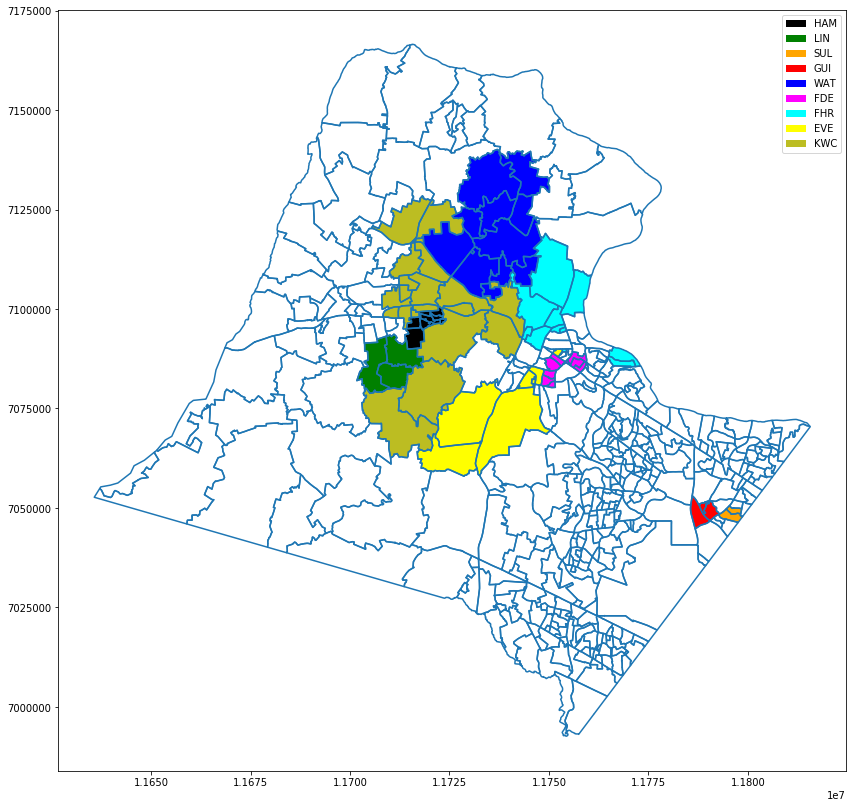

In [464]:
legend_handles = [Patch(facecolor='black', label='HAM'),
                  Patch(facecolor='green', label='LIN'),
                  Patch(facecolor='orange', label='SUL'),
                   Patch(facecolor='red', label='GUI'),
                   Patch(facecolor='blue', label='WAT'),
                   Patch(facecolor='magenta', label='FDE'),
                   Patch(facecolor='cyan', label='FHR'),
                   Patch(facecolor='yellow', label='EVE'),
                   Patch(facecolor='tab:olive', label='KWC')
                ]

ax = spas.boundary.plot(figsize=(15,14))
spas[spas['ELEM_CODE'] == 'HAM'].plot(ax=ax, color='black')
spas[spas['ELEM_CODE'] == 'LIN'].plot(ax=ax, color='green')
spas[spas['ELEM_CODE'] == 'SUL'].plot(ax=ax, color='orange')

spas[spas['ELEM_CODE'] == 'GUI'].plot(ax=ax, color='red')
spas[spas['ELEM_CODE'] == 'WAT'].plot(ax=ax, color='blue')
spas[spas['ELEM_CODE'] == 'FDE'].plot(ax=ax, color='magenta')

spas[spas['ELEM_CODE'] == 'FHR'].plot(ax=ax, color='cyan')
spas[spas['ELEM_CODE'] == 'EVE'].plot(ax=ax, color='yellow')
spas[spas['ELEM_CODE'] == 'KWC'].plot(ax=ax, color='tab:olive')

# ax.legend
ax.legend(handles=legend_handles)

In [465]:
# from numpy import concatenate
# import pandas as pd

col_level_1 = np.concatenate([[i]*2 for i in interested_districts])
col_level_2 = ['W', 'NW'] * len(interested_districts)
cols_combined = zip(col_level_1, col_level_2)
col_index = pd.MultiIndex.from_tuples(cols_combined, names=["District", "Group"])
row_index = pd.Index(range(1,26))
combined_df = pd.DataFrame(data=data_array, index = row_index, columns = col_index)
combined_df 

District       GUI                 SUL                 LIN            \
Group            W        NW         W        NW         W        NW   
1         0.069565  0.930435  0.115502  0.884498  0.845178  0.154822   
2         0.133333  0.866667  0.111111  0.888889  0.826347  0.173653   
3         0.151102  0.848898  0.120053  0.879947  0.821138  0.178862   
4         0.147378  0.852622  0.113475  0.886525  0.877193  0.122807   
5         0.094523  0.905477  0.138075  0.861925  0.810345  0.189655   
6         0.156277  0.843723  0.109551  0.890449  0.700201  0.299799   
7         0.069565  0.930435  0.122396  0.877604  0.818662  0.181338   
8         0.069565  0.930435  0.127168  0.872832  0.862876  0.137124   
9         0.088210  0.911790  0.155251  0.844749  0.808696  0.191304   
10        0.151102  0.848898  0.128743  0.871257  0.753452  0.246548   
11        0.093470  0.906530  0.145995  0.854005  0.847953  0.152047   
12        0.093795  0.906205  0.138444  0.861556  0.909871  0.090129   
13        0.156983  0.843017  0.121951  0.878049  0.869718  0.130282   
14        0.080997  0.919003  0.127976  0.872024  0.859287  0.140713   
15        0.138175  0.861825  0.127714  0.872286  0.866803  0.133197   
16        0.076712  0.923288  0.111111  0.888889  0.817955  0.182045   
17        0.067669  0.932331  0.166102  0.833898  0.836923  0.163077   
18        0.151899  0.848101  0.113475  0.886525  0.732773  0.267227   
19        0.081044  0.918956  0.145995  0.854005  0.860215  0.139785   
20        0.089918  0.910082  0.138075  0.861925  0.770833  0.229167   
21        0.138475  0.861525  0.121951  0.878049  0.854015  0.145985   
22        0.162080  0.837920  0.109551  0.890449  0.741824  0.258176   
23        0.132832  0.867168  0.103491  0.896509  0.690184  0.309816   
24        0.136275  0.863725  0.171480  0.828520  0.820463  0.179537   
25        0.249480  0.750520  0.105546  0.894454  0.863636  0.136364   

District       FHR                 HAM                 KWC            \
Group            W        NW         W        NW         W        NW   
1         0.806452  0.193548  0.828283  0.171717  0.720430  0.279570   
2         0.835391  0.164609  0.804124  0.195876  0.821053  0.178947   
3         0.686591  0.313409  0.818182  0.181818  0.726027  0.273973   
4         0.877551  0.122449  0.824885  0.175115  0.788462  0.211538   
5         0.797900  0.202100  0.863636  0.136364  0.836364  0.163636   
6         0.810000  0.190000  0.856209  0.143791  0.914286  0.085714   
7         0.740541  0.259459  0.887500  0.112500  0.815951  0.184049   
8         0.819905  0.180095  0.824324  0.175676  0.831050  0.168950   
9         0.631696  0.368304  0.844660  0.155340  0.727273  0.272727   
10        0.724409  0.275591  0.787356  0.212644  0.784247  0.215753   
11        0.699029  0.300971  0.807843  0.192157  0.795987  0.204013   
12        0.728155  0.271845  0.785185  0.214815  0.870307  0.129693   
13        0.766129  0.233871  0.775362  0.224638  0.721649  0.278351   
14        0.756410  0.243590  0.859873  0.140127  0.768939  0.231061   
15        0.781977  0.218023  0.877133  0.122867  0.850299  0.149701   
16        0.734280  0.265720  0.897361  0.102639  0.761468  0.238532   
17        0.741240  0.258760  0.856000  0.144000  0.848315  0.151685   
18        0.684049  0.315951  0.859259  0.140741  0.842271  0.157729   
19        0.318828  0.681172  0.848889  0.151111  0.800000  0.200000   
20        0.688144  0.311856  0.861789  0.138211  0.728736  0.271264   
21        0.711744  0.288256  0.826531  0.173469  0.816568  0.183432   
22        0.710900  0.289100  0.783069  0.216931  0.913043  0.086957   
23        0.666667  0.333333  0.792857  0.207143  0.840278  0.159722   
24        0.642857  0.357143  0.862745  0.137255  0.822695  0.177305   
25        0.680851  0.319149  0.876712  0.123288  0.763240  0.236760   

District       WAT                 EVE                 FDE            \
Group            W        NW         W

In [466]:
data_raw = spas_grouped.loc[interested_districts, ['ELEM_POP_W','ELEM_POP_NW']]
data_original = data_raw.values.reshape((1,len(interested_districts)*2))
original_df =  pd.DataFrame(data=data_original, columns = col_index)
# print(data_raw.values)
original_df

District       GUI                 SUL                 LIN            \
Group            W        NW         W        NW         W        NW   
0         0.079687  0.920312  0.111111  0.888889  0.884211  0.115789   

District       FHR                 HAM                 KWC            \
Group            W        NW         W        NW         W        NW   
0         0.579161  0.420839  0.803468  0.196532  0.837121  0.162879   

District       WAT                 EVE                 FDE               SUG  \
Group            W        NW         W        NW         W        NW       W   
0         0.814815  0.185185  0.475687  0.524313  0.361496  0.638504  0.1354   

District          
Group         NW  
0         0.8646

Text(0, 0.5, 'Percentages')

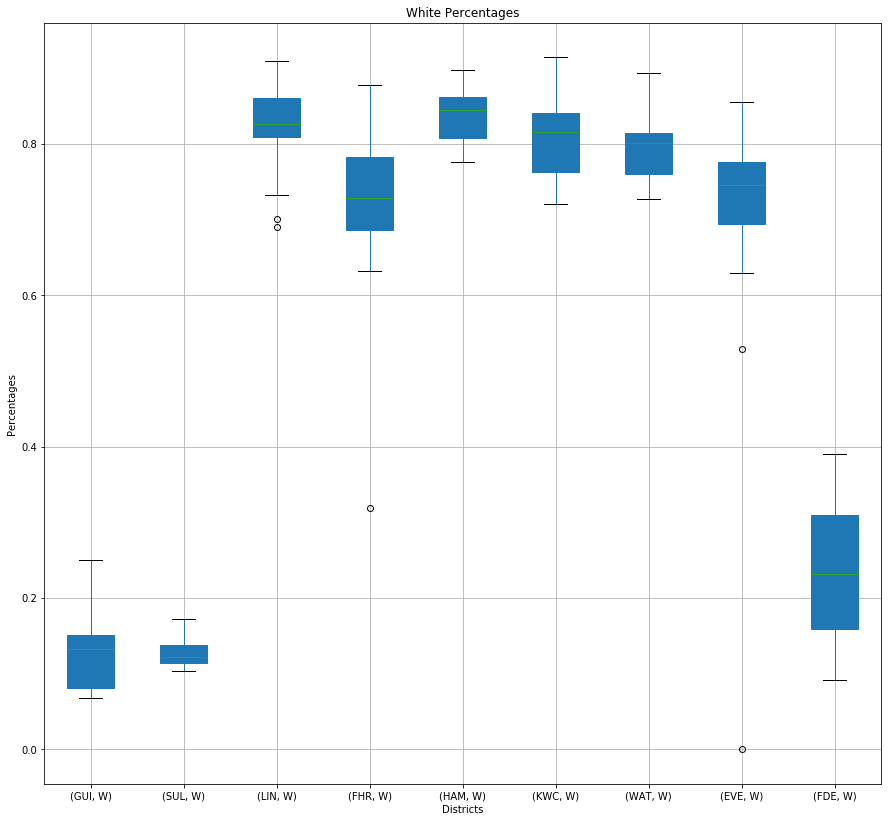

In [467]:
white_column=[('GUI','W'), ('SUL','W'), ('LIN','W'),  ('FHR','W'),  ('HAM','W'),  ('KWC','W'), ('WAT','W'), ('EVE','W'), ('FDE', 'W')]
ax, props = combined_df.boxplot(column=white_column, figsize=(15,14), return_type='both', patch_artist=True)
ax.set_title('White Percentages')
ax.set_xlabel('Districts')
ax.set_ylabel('Percentages')

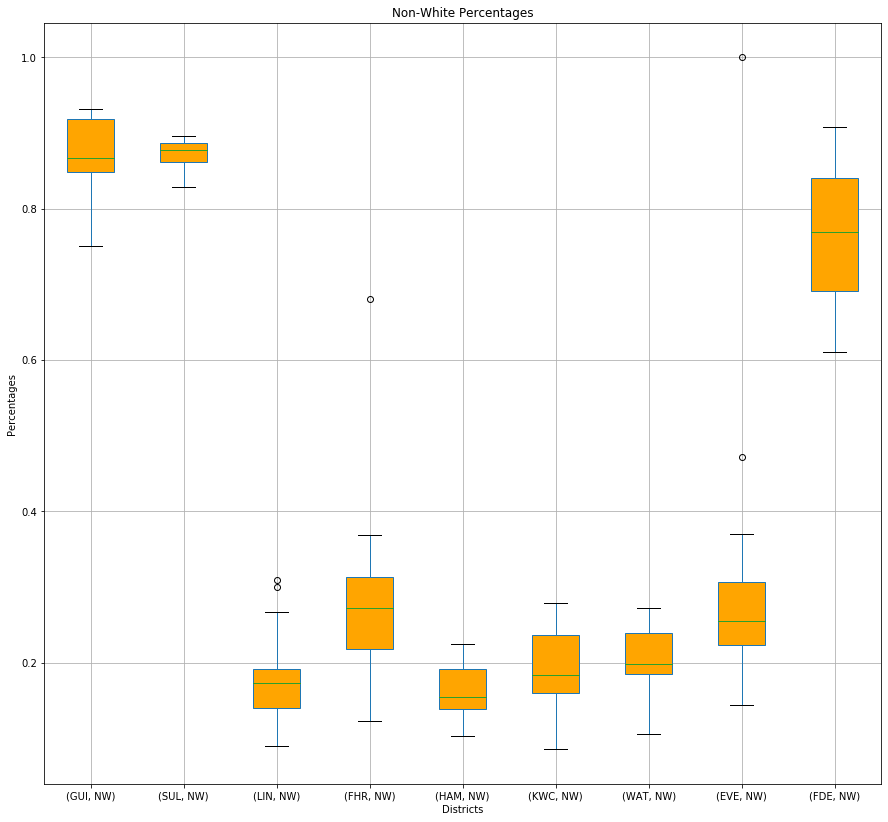

In [468]:
nonwhite_column=[('GUI','NW'), ('SUL','NW'), ('LIN','NW'),  ('FHR','NW'),  ('HAM','NW'),  ('KWC','NW'), ('WAT','NW'), ('EVE','NW'), ('FDE','NW')]
ax, props = combined_df.boxplot(column=nonwhite_column, figsize=(15,14), return_type='both', patch_artist=True)
ax.set_title('Non-White Percentages')
ax.set_xlabel('Districts')
ax.set_ylabel('Percentages')
for box in props['boxes']:
    box.set_facecolor('orange')

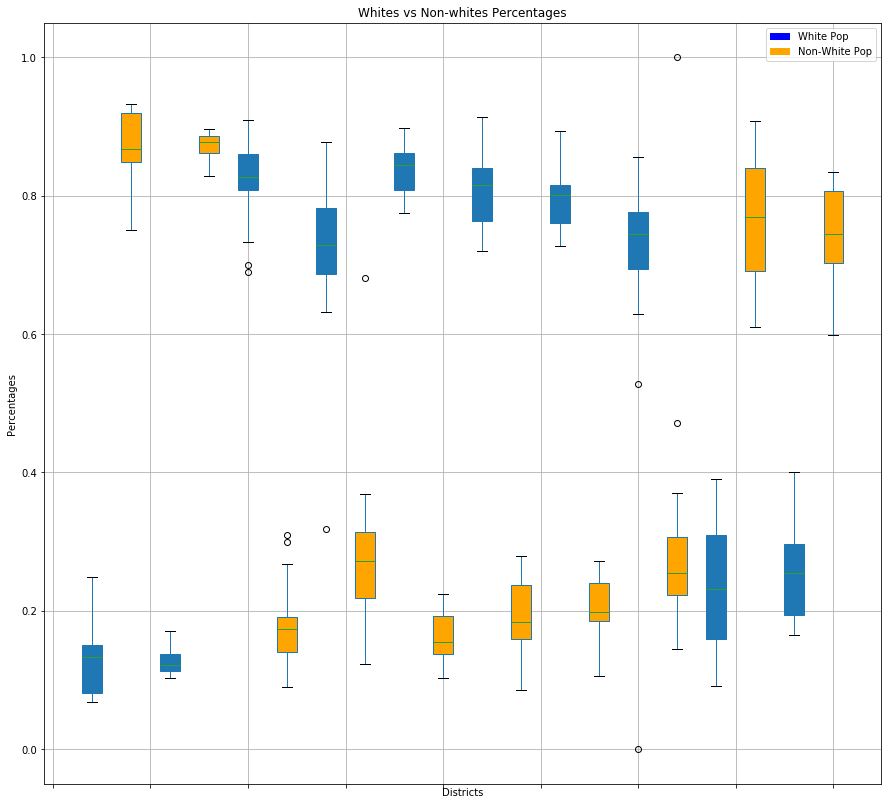

In [469]:
import matplotlib.pyplot as plt

ax, props = combined_df.boxplot(figsize=(15,14), return_type='both', patch_artist=True, manage_ticks=False)
ax.set_title('Whites vs Non-whites Percentages')
ax.set_xlabel('Districts')
ax.set_ylabel('Percentages')
num_boxes = len(props['boxes'])
for i in range(1, num_boxes, 2):
    props['boxes'][i].set_facecolor('orange')
    
legend_handles = [Patch(facecolor='blue', label='White Pop'),
                Patch(facecolor='orange', label='Non-White Pop')]
ax.legend(handles=legend_handles)

plt.tick_params(labelbottom=False)

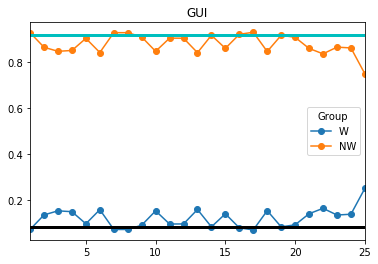

In [470]:
# ax = combined_df['GUI'].plot(marker='o', subplots=True)
# pic_folder = 'Combined_linegraphs_andboxplots'

ax = combined_df['GUI'].plot(marker='o')
ax.set_title("GUI")
x = np.arange(1,26)
yw = [spas_grouped.loc['GUI', 'ELEM_POP_W']] * 25
ynw = [spas_grouped.loc['GUI', 'ELEM_POP_NW']] * 25
ax.plot(x,yw,color='k', linewidth='3')
ax.plot(x,ynw,color='c', linewidth='3')
# ax.legend()
ax.get_figure().savefig('GUI_compare_{}'.format(algo))

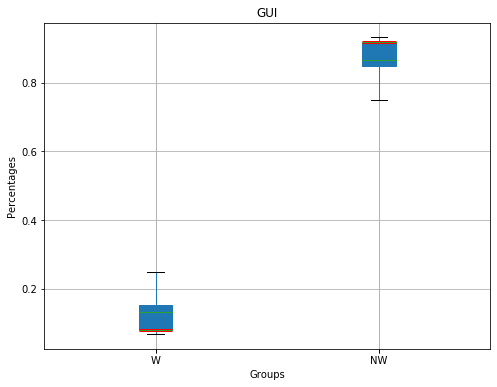

In [471]:
ax =  combined_df['GUI'].boxplot(figsize=(8,6), patch_artist=True)
ax.set_title('GUI')
ax.set_xlabel('Groups')
ax.set_ylabel('Percentages')


ax,bp_key = original_df['GUI'].boxplot(ax=ax, return_type='both', patch_artist=True)
for box in bp_key['boxes']:
    box.set_color('red')
    box.set_linewidth(3)
    
ax.get_figure().savefig('GUI_combined_{}'.format(algo))

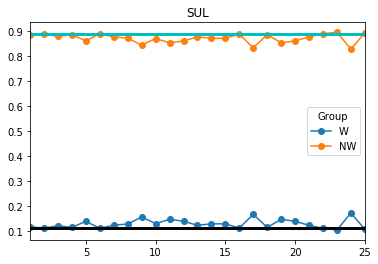

In [472]:
ax = combined_df['SUL'].plot(marker='o')
ax.set_title("SUL")
yw = [spas_grouped.loc['SUL', 'ELEM_POP_W']] * 25
ynw = [spas_grouped.loc['SUL', 'ELEM_POP_NW']] * 25
ax.plot(x,yw,color='k', linewidth='3')
ax.plot(x,ynw,color='c', linewidth='3')
ax.get_figure().savefig('SUL_compare_{}'.format(algo))

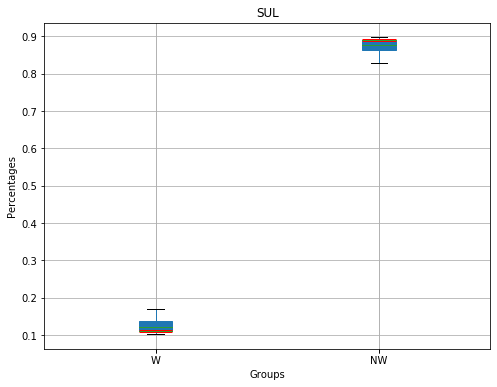

In [473]:
ax =  combined_df['SUL'].boxplot(figsize=(8,6), patch_artist=True)
ax.set_title('SUL')
ax.set_xlabel('Groups')
ax.set_ylabel('Percentages')

ax,bp_key = original_df['SUL'].boxplot(ax=ax, return_type='both', patch_artist=True)
for box in bp_key['boxes']:
    box.set_color('red')
    box.set_linewidth(3)
    
ax.get_figure().savefig('SUL_combined_{}'.format(algo))

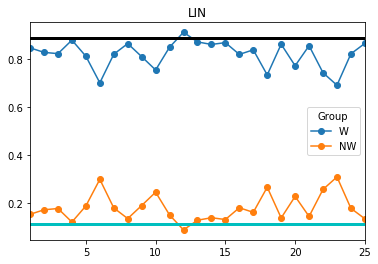

In [474]:
ax = combined_df['LIN'].plot(marker='o')
ax.set_title("LIN")
yw = [spas_grouped.loc['LIN', 'ELEM_POP_W']] * 25
ynw = [spas_grouped.loc['LIN', 'ELEM_POP_NW']] * 25
ax.plot(x,yw,color='k', linewidth='3')
ax.plot(x,ynw,color='c', linewidth='3')
ax.get_figure().savefig('LIN_compare_{}'.format(algo))

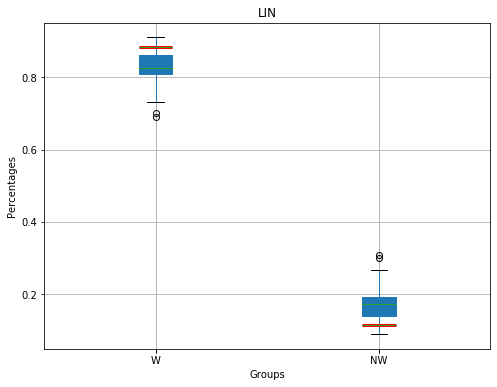

In [475]:
ax =  combined_df['LIN'].boxplot(figsize=(8,6), patch_artist=True)
ax.set_title('LIN')
ax.set_xlabel('Groups')
ax.set_ylabel('Percentages')

ax,bp_key = original_df['LIN'].boxplot(ax=ax, return_type='both', patch_artist=True)
for box in bp_key['boxes']:
    box.set_color('red')
    box.set_linewidth(3)
    
    
ax.get_figure().savefig('LIN_combined_{}'.format(algo))

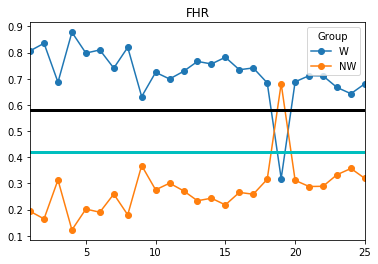

In [476]:
ax = combined_df['FHR'].plot(marker='o')
ax.set_title("FHR")
yw = [spas_grouped.loc['FHR', 'ELEM_POP_W']] * 25
ynw = [spas_grouped.loc['FHR', 'ELEM_POP_NW']] * 25
ax.plot(x,yw,color='k', linewidth='3')
ax.plot(x,ynw,color='c', linewidth='3')
ax.get_figure().savefig('FHR_compare_{}'.format(algo))

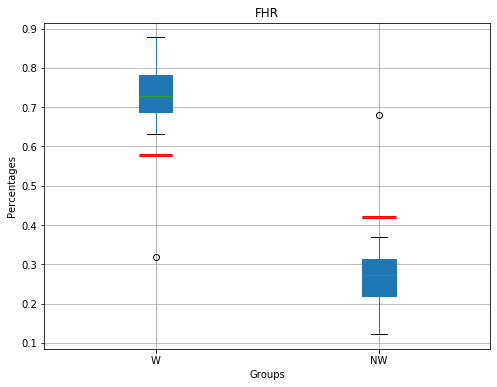

In [477]:
ax =  combined_df['FHR'].boxplot(figsize=(8,6), patch_artist=True)
ax.set_title('FHR')
ax.set_xlabel('Groups')
ax.set_ylabel('Percentages')

ax,bp_key = original_df['FHR'].boxplot(ax=ax, return_type='both', patch_artist=True)
for box in bp_key['boxes']:
    box.set_color('red')
    box.set_linewidth(3)
    
    
ax.get_figure().savefig('FHR_combined_{}'.format(algo))

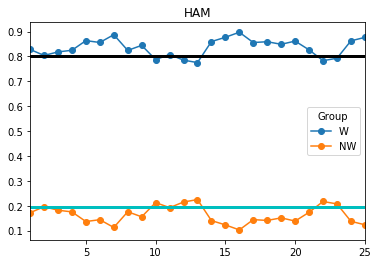

In [478]:
ax = combined_df['HAM'].plot(marker='o')
ax.set_title("HAM")
yw = [spas_grouped.loc['HAM', 'ELEM_POP_W']] * 25
ynw = [spas_grouped.loc['HAM', 'ELEM_POP_NW']] * 25
ax.plot(x,yw,color='k', linewidth='3')
ax.plot(x,ynw,color='c', linewidth='3')

ax.get_figure().savefig('HAM_compare_{}'.format(algo))

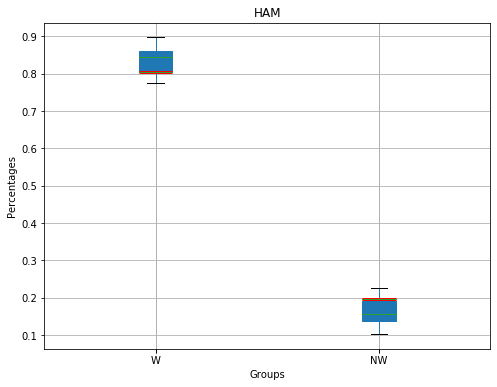

In [479]:
ax =  combined_df['HAM'].boxplot(figsize=(8,6), patch_artist=True)
ax.set_title('HAM')
ax.set_xlabel('Groups')
ax.set_ylabel('Percentages')

ax,bp_key = original_df['HAM'].boxplot(ax=ax, return_type='both', patch_artist=True)
for box in bp_key['boxes']:
    box.set_color('red')
    box.set_linewidth(3)
    
ax.get_figure().savefig('HAM_combined_{}'.format(algo))

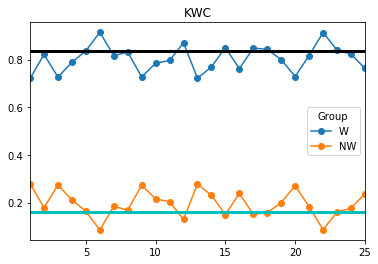

In [480]:
ax = combined_df['KWC'].plot(marker='o')
ax.set_title("KWC")
yw = [spas_grouped.loc['KWC', 'ELEM_POP_W']] * 25
ynw = [spas_grouped.loc['KWC', 'ELEM_POP_NW']] * 25
ax.plot(x,yw,color='k', linewidth='3')
ax.plot(x,ynw,color='c', linewidth='3')
ax.get_figure().savefig('KWC_compare_{}'.format(algo))

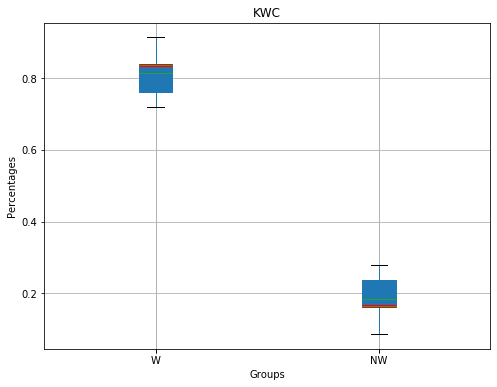

In [481]:
ax =  combined_df['KWC'].boxplot(figsize=(8,6), patch_artist=True)
ax.set_title('KWC')
ax.set_xlabel('Groups')
ax.set_ylabel('Percentages')

ax,bp_key = original_df['KWC'].boxplot(ax=ax, return_type='both', patch_artist=True)
for box in bp_key['boxes']:
    box.set_color('red')
    box.set_linewidth(3)
    
ax.get_figure().savefig('KWC_combined_{}'.format(algo))

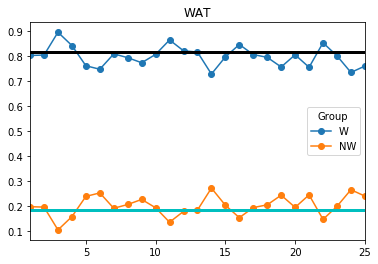

In [482]:
ax = combined_df['WAT'].plot(marker='o')
ax.set_title("WAT")
yw = [spas_grouped.loc['WAT', 'ELEM_POP_W']] * 25
ynw = [spas_grouped.loc['WAT', 'ELEM_POP_NW']] * 25
ax.plot(x,yw,color='k', linewidth='3')
ax.plot(x,ynw,color='c', linewidth='3')
ax.get_figure().savefig('WAT_compare_{}'.format(algo))

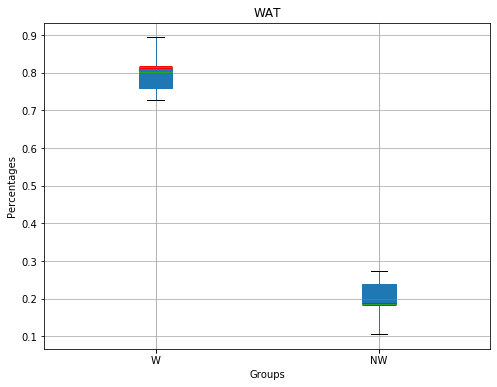

In [483]:
ax =  combined_df['WAT'].boxplot(figsize=(8,6), patch_artist=True)
ax.set_title('WAT')
ax.set_xlabel('Groups')
ax.set_ylabel('Percentages')

ax,bp_key = original_df['WAT'].boxplot(ax=ax, return_type='both', patch_artist=True)
for box in bp_key['boxes']:
    box.set_color('red')
    box.set_linewidth(3)
    
ax.get_figure().savefig('WAT_combined_{}'.format(algo))

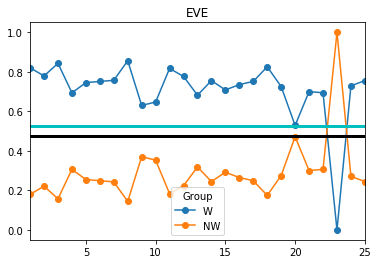

In [484]:
ax = combined_df['EVE'].plot(marker='o')
ax.set_title("EVE")
yw = [spas_grouped.loc['EVE', 'ELEM_POP_W']] * 25
ynw = [spas_grouped.loc['EVE', 'ELEM_POP_NW']] * 25
ax.plot(x,yw,color='k', linewidth='3')
ax.plot(x,ynw,color='c', linewidth='3')

ax.get_figure().savefig('EVE_compare_{}'.format(algo))

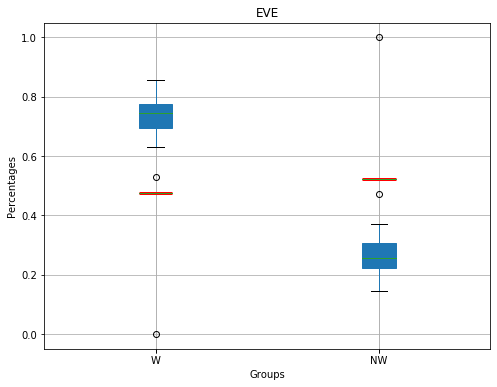

In [485]:
ax =  combined_df['EVE'].boxplot(figsize=(8,6), patch_artist=True)
ax.set_title('EVE')
ax.set_xlabel('Groups')
ax.set_ylabel('Percentages')

ax,bp_key = original_df['EVE'].boxplot(ax=ax, return_type='both', patch_artist=True)
for box in bp_key['boxes']:
    box.set_color('red')
    box.set_linewidth(3)
    
ax.get_figure().savefig('EVE_combined_{}'.format(algo))

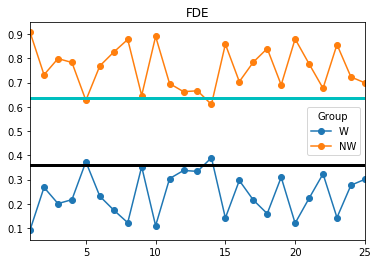

In [486]:
ax = combined_df['FDE'].plot(marker='o')
ax.set_title("FDE")
yw = [spas_grouped.loc['FDE', 'ELEM_POP_W']] * 25
ynw = [spas_grouped.loc['FDE', 'ELEM_POP_NW']] * 25
ax.plot(x,yw,color='k', linewidth='3')
ax.plot(x,ynw,color='c', linewidth='3')

ax.get_figure().savefig('FDE_compare_{}'.format(algo))
# this is for the original data, i think
# I can see that the original data seems to be optimized here, since the gap is closer than the output plans
# The original is generally good though, in most cases - just for this district and SA

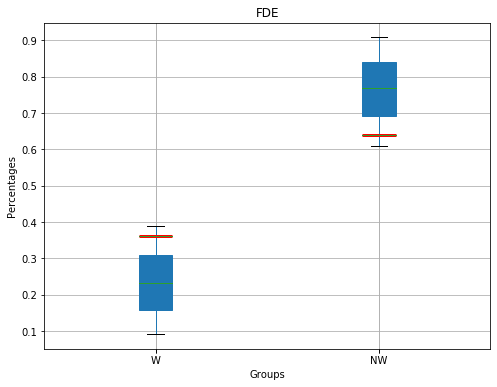

In [487]:
ax =  combined_df['FDE'].boxplot(figsize=(8,6), patch_artist=True)
ax.set_title('FDE')
ax.set_xlabel('Groups')
ax.set_ylabel('Percentages')

ax,bp_key = original_df['FDE'].boxplot(ax=ax, return_type='both', patch_artist=True)
for box in bp_key['boxes']:
    box.set_color('red')
    box.set_linewidth(3)
    
ax.get_figure().savefig('FDE_combined_{}'.format(algo))

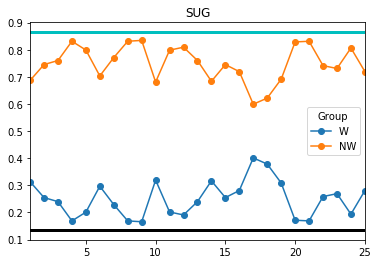

In [488]:
ax = combined_df['SUG'].plot(marker='o')
ax.set_title("SUG")
yw = [spas_grouped.loc['SUG', 'ELEM_POP_W']] * 25
ynw = [spas_grouped.loc['SUG', 'ELEM_POP_NW']] * 25
ax.plot(x,yw,color='k', linewidth='3')
ax.plot(x,ynw,color='c', linewidth='3')
ax.get_figure().savefig('SUG_compare_{}'.format(algo))

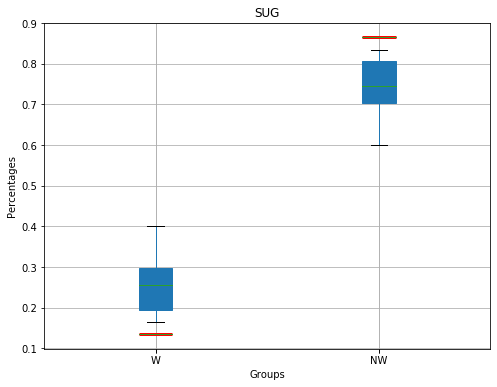

In [489]:
ax =  combined_df['SUG'].boxplot(figsize=(8,6), patch_artist=True)
ax.set_title('SUG')
ax.set_xlabel('Groups')
ax.set_ylabel('Percentages')

ax,bp_key = original_df['SUG'].boxplot(ax=ax, return_type='both', patch_artist=True)
for box in bp_key['boxes']:
    box.set_color('red')
    box.set_linewidth(3)
    
ax.get_figure().savefig('SUG_combined_{}'.format(algo))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000020B6F51C388>,
      dtype=object)

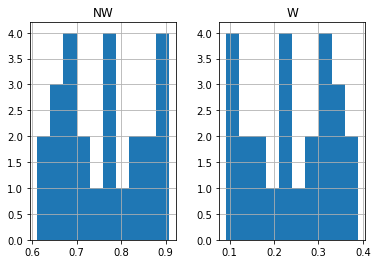

In [490]:
combined_df['FDE'].hist()

In [491]:
segregated_entropy
#this is for the original data

,ELEM_POP_W,ELEM_POP_NW,ABS_DIFF,ENTROPY_IND
ELEM_CODE,,,,
GUI,0.079687,0.920312,0.840625,0.278005
LIN,0.884211,0.115789,0.768421,0.358451
SUG,0.135400,0.864600,0.729201,0.396524
SUL,0.111111,0.888889,0.777778,0.348832


In [492]:
ind_diss


[0.3411405684367161,
 0.3185294639996755,
 0.31927487928917014,
 0.3538578383566726,
 0.3362985692728846,
 0.3374409932157744,
 0.32283176057848634,
 0.35414229645700784,
 0.3044650591987197,
 0.32154887812227184,
 0.3280429844684689,
 0.3366357188742663,
 0.3243581404451334,
 0.310957256147372,
 0.3207857577050129,
 0.3285990512997348,
 0.318642461459545,
 0.3246013190404555,
 0.3122454218896442,
 0.3255822657323285,
 0.3296818780391565,
 0.33776213208353334,
 0.34617975703440934,
 0.2916806175653218,
 0.33171192686747275,
 0.3410679390529909,
 0.32350270617950716,
 0.3103791276637435,
 0.33663078456047957,
 0.3333891309476537,
 0.3120812636574721,
 0.3132998676436575,
 0.34520769571674176,
 0.3322843561806571,
 0.32777116744918383,
 0.32232688773374396,
 0.335865220105751,
 0.3232635029744405,
 0.3218321792888248,
 0.35487253584105816,
 0.3343153033772391,
 0.31777021941120986,
 0.3182021154034625,
 0.32657062792458397,
 0.33628138547992287,
 0.3247555578349883,
 0.33190428576889547,

(array([ 0.,  3.,  3., 20., 35., 23.,  9.,  7.,  0.,  0.,  0.]),
 array([0.28, 0.29, 0.3 , 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38,
        0.39]),
 <a list of 11 Patch objects>)

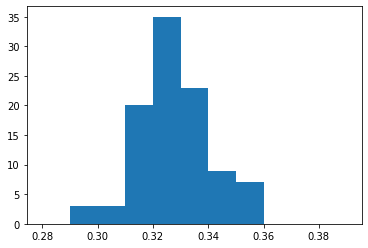

In [493]:
plt.hist(ind_diss, bins=[y/100 for y in range(28,40)])
# plt.axis([0, 25, 0.25, 0.50])
# plt.show()

#challenge with plotting histogram. Any help will be much appreciated